In [34]:
import pandas as pd
import os
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed

def read_and_process_csv_files(directory, start_year, end_year, chunksize=500000, processed_dir='processed_chunks'):
    if not os.path.exists(processed_dir):
        os.makedirs(processed_dir)

    for year in range(start_year, end_year + 1):
        filename = f'{year}.csv'
        file_path = os.path.join(directory, filename)
        
        if os.path.exists(file_path):
            dtype_dict = {
                'ORIGIN': str,
                'DEST': str,
                'CANCELLED': float,
                'CRS_ELAPSED_TIME': float,
                'FL_DATE': str,
                'OP_CARRIER': str
            }
            
            usecols = ['CANCELLED', 'OP_CARRIER', 'ORIGIN', 'DEST', 'CRS_DEP_TIME', 'FL_DATE']
            
            # Count the total number of chunks to be processed
            total_chunks = sum(1 for _ in pd.read_csv(file_path, chunksize=chunksize, usecols=usecols))
            
            # Use tqdm for progress bar
            with tqdm(total=total_chunks, desc=f'Processing {filename}') as pbar:
                chunk_iter = pd.read_csv(file_path, chunksize=chunksize, dtype=dtype_dict, usecols=usecols)
                
                # Create a ThreadPoolExecutor with a reasonable number of threads
                with ThreadPoolExecutor(max_workers=os.cpu_count() * 2) as executor:
                    futures = []
                    chunk_count = 0
                    for chunk in chunk_iter:
                        if 'CANCELLED' not in chunk.columns:
                            print(f"'CANCELLED' column is missing in chunk {chunk_count} of {filename}")
                            continue
                        
                        # Submit each chunk processing task to the executor
                        future = executor.submit(process_chunk, chunk.copy(), chunk_count, filename)
                        futures.append(future)
                        
                        chunk_count += 1
                        pbar.update(1)  # Update progress bar by 1 chunk
            
            # Wait for all futures to complete
            for future in as_completed(futures):
                prepared_chunk, chunk_count, filename = future.result()
                if prepared_chunk.empty:
                    print(f"Prepared chunk {chunk_count} of {filename} is empty.")
                else:
                    os.makedirs(os.path.join(processed_dir, f'{year}'), exist_ok=True)
                    processed_chunk_file = os.path.join(processed_dir, f'{year}', f'chunk_{year}_{chunk_count}.csv')
                    prepared_chunk.to_csv(processed_chunk_file, index=False)                        
        
        else:
            print(f"File {filename} does not exist in the directory.")

def process_chunk(chunk, chunk_count, filename):
    cleaned_chunk = clean_data(chunk)
    prepared_chunk = prepare_data(cleaned_chunk)
    
    return prepared_chunk, chunk_count, filename

def clean_data(df):
    df = df.drop_duplicates()

    numerical_columns = df.select_dtypes(include=['number']).columns
    df.loc[:, numerical_columns] = df.loc[:, numerical_columns].fillna(df.loc[:, numerical_columns].mean())

    categorical_columns = df.select_dtypes(include=['object']).columns
    for col in categorical_columns:
        mode_value = df[col].mode()[0]
        df.loc[:, col] = df.loc[:, col].fillna(mode_value)

    df = df.dropna()

    return df

def frequency_encode(df, column):
    freq_encoding = df.groupby(column).size() / len(df)
    df[column + '_FE'] = df[column].map(freq_encoding)
    df.drop(column, axis=1, inplace=True)
    return df

def prepare_data(df):
    df['FL_DATE'] = pd.to_datetime(df['FL_DATE'], errors='coerce')
    df = df.dropna(subset=['FL_DATE'])

    df['MONTH'] = df['FL_DATE'].dt.month
    df['DAY_OF_WEEK'] = df['FL_DATE'].dt.dayofweek
    
    df['CRS_DEP_TIME'] = pd.to_numeric(df['CRS_DEP_TIME'], errors='coerce')
    df['CRS_DEP_TIME'] = df['CRS_DEP_TIME'].fillna(0).astype(int)
    
    df['CRS_DEP_TIME'] = df['CRS_DEP_TIME'].apply(lambda x: int(str(x).zfill(4)[:2]))
    
    df.drop(columns=['FL_DATE'], inplace=True)
    
    df = frequency_encode(df, 'OP_CARRIER')
    df = frequency_encode(df, 'ORIGIN')
    df = frequency_encode(df, 'DEST')
    
    return df

### Data preparation and analysis

In [43]:
# Specify the directory and range of years
directory = 'data/'
start_year = 2009
end_year = 2018

# Process and save the chunks (assuming read_and_process_csv_files function is defined)
read_and_process_csv_files(directory, start_year, end_year)

Processing 2018.csv: 100%|██████████| 15/15 [00:12<00:00,  1.24it/s]


In [37]:
import os
import pandas as pd

processed_dir = 'processed_chunks'

years = [f for f in os.listdir(processed_dir) if os.path.isdir(os.path.join(processed_dir, f))]
dfs = []

for year in years:
    year_dir = os.path.join(processed_dir, year)
    files = [os.path.join(year_dir, f) for f in os.listdir(year_dir) if f.startswith('chunk_') and f.endswith('.csv')]
    
    for file in files:
        df = pd.read_csv(file)
        dfs.append(df)

combined_df = pd.concat(dfs, ignore_index=True)

In [38]:
# Separate features and target
X = combined_df.drop(columns=['CANCELLED'])
y = combined_df['CANCELLED']

# Check unique values to ensure binary classification
print(f'Unique values in target variable: {y.unique()}')


Unique values in target variable: [0. 1.]


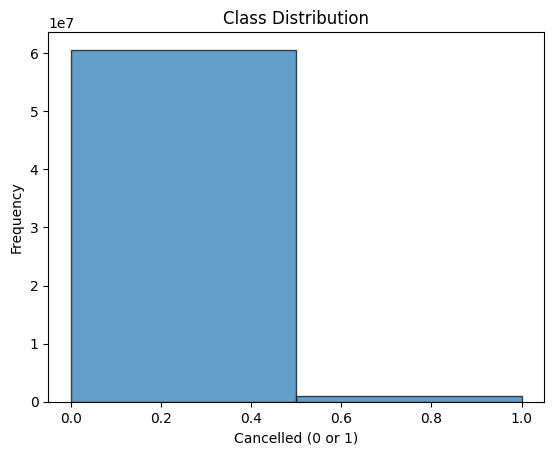

CANCELLED
0.0    60574326
1.0      973063
Name: count, dtype: int64


In [39]:
import matplotlib.pyplot as plt

# Plot the class distribution using matplotlib
plt.hist(y, bins=2, edgecolor='k', alpha=0.7)
plt.title('Class Distribution')
plt.xlabel('Cancelled (0 or 1)')
plt.ylabel('Frequency')
plt.show()

# Print class distribution
print(y.value_counts())

In [40]:
# Split the dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


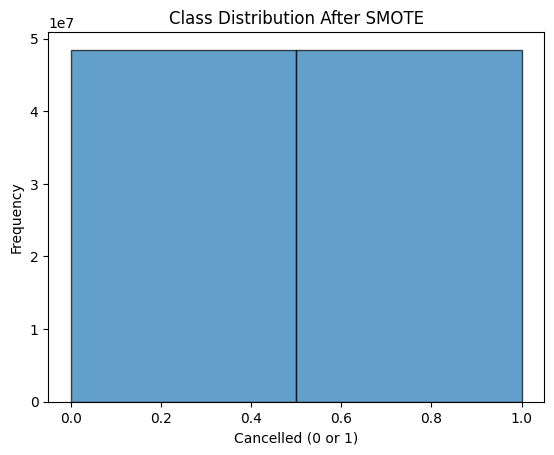

CANCELLED
0.0    48459461
1.0    48459461
Name: count, dtype: int64


In [41]:
# Apply SMOTE to the training data
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

# Verify the new class distribution
import matplotlib.pyplot as plt

plt.hist(y_resampled, bins=2, edgecolor='k', alpha=0.7)
plt.title('Class Distribution After SMOTE')
plt.xlabel('Cancelled (0 or 1)')
plt.ylabel('Frequency')
plt.show()

# Print new class distribution
print(y_resampled.value_counts())

In [42]:
# Initialize and train the model on the resampled data
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_resampled, y_resampled)

# Make predictions on the original test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{class_report}')

Accuracy: 0.9733160090135422
Confusion Matrix:
[[11960675   154190]
 [  174276    20337]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99  12114865
         1.0       0.12      0.10      0.11    194613

    accuracy                           0.97  12309478
   macro avg       0.55      0.55      0.55  12309478
weighted avg       0.97      0.97      0.97  12309478

